# Processing of Momeni masks

In [1]:
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist

import cmbnet.preprocessing.loading as utils_datasets
from cmbnet.preprocessing.datasets.momeni import load_MOMENI_raw, process_MOMENI_anno
import cmbnet.visualization.utils_plotting as utils_plt
import os
from typing import Tuple, List, Dict
import matplotlib.pyplot as plt


In [2]:
input_dir = "/home/cerebriu/data/datasets/raw/MOMENI"
subjects = utils_datasets.get_dataset_subjects("momeni", input_dir)
idx = 0
subject = subjects[idx]
print(subject)

sequences_raw, labels_raw, sequence_type, centersofmass = load_MOMENI_raw(input_dir, subject)

239_T1_MRI_SWI_BFC_50mm_HM


In [3]:
centersofmass

[(54, 116, 40), (47, 161, 38)]

In [4]:
comss =centersofmass
comms = [(117, 271, 64)]
mri_im = sequences_raw['SWI']
mri_data = mri_im.get_fdata()

labels_procesed, metadata, msg = process_MOMENI_anno( mri_im, comss , "")

Looping over tolerances:  58%|█████▊    | 1168/2000 [00:05<00:03, 211.19it/s]


In [5]:
metadata

[{'n_pixels': 1,
  'tolerance_selected': 43.7,
  'tolerance_pixel_counts': [1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   1,
   

In [6]:
print(msg)

		Maximum distance allowed (voxels)=6 Size threshold=174.
		Processing CMB annotations 
		Processed CMB 0. center of mass=(54, 116, 40), new_size=1
		Processed CMB 1. center of mass=(47, 161, 38), new_size=4



In [7]:
def apply_2D_zoom(image, zoom_coords, zoom_size):
    if zoom_coords and zoom_size:
        x_center, y_center = zoom_coords
        half_size = zoom_size // 2

        # Ensure the zoom region doesn't exceed the image dimensions
        x_start = (x_center - half_size)
        y_start = (y_center - half_size)
        x_end = (x_center + half_size)
        y_end = (y_center + half_size)

        newim = image[y_start:y_end, x_start:x_end]
        return newim
    return image

def adjust_for_radiological_view(image: np.ndarray) -> np.ndarray:
    """
    Adjusts the image for the radiological view by rotating it 90 degrees.

    Args:
        image (np.ndarray): The 2D numpy array representing the MRI slice.

    Returns:
        np.ndarray: The rotated image.
    """
    return np.rot90(image)

def plot_processed_mask_2x2(mri_data, cmb_data, out_mask, cmb_coords, seq_type, zoom_coords=None, zoom_size=None):
    """
    Adjusted to plot in a 2x2 layout.
    """
    assert len(cmb_coords) == 3
    if zoom_coords is None:
        zoom_coords = cmb_coords[:2]
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # Adjust subplot layout to 2x2
    
    # Original MRI image
    zoomed_mri = apply_2D_zoom(mri_data[:, :, cmb_coords[-1]], zoom_coords, zoom_size)
    axs[0, 0].imshow(adjust_for_radiological_view(zoomed_mri), cmap='gray')
    axs[0, 0].set_title(f'{seq_type} MRI')
    axs[0, 0].axis('off')
    
    # Original Mask
    zoomed_mask = apply_2D_zoom(cmb_data[:, :, cmb_coords[-1]], zoom_coords, zoom_size)
    axs[0, 1].imshow(adjust_for_radiological_view(zoomed_mask), cmap='gray')
    axs[0, 1].set_title('Original Mask')
    axs[0, 1].axis('off')
    
    # Ground Truth Overlay
    axs[1, 0].imshow(adjust_for_radiological_view(zoomed_mri), cmap='gray')
    axs[1, 0].imshow(adjust_for_radiological_view(zoomed_mask), alpha=0.5, cmap="Reds")
    axs[1, 0].set_title('Ground Truth Overlay')
    axs[1, 0].axis('off')
    
    # Generated Mask Overlay
    zoomed_generated_mask = apply_2D_zoom(out_mask[:, :, cmb_coords[-1]], zoom_coords, zoom_size)
    axs[1, 1].imshow(adjust_for_radiological_view(zoomed_mri), cmap='gray')
    axs[1, 1].imshow(adjust_for_radiological_view(zoomed_generated_mask), alpha=0.5, cmap="Reds")
    axs[1, 1].set_title('Generated Mask Overlay')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

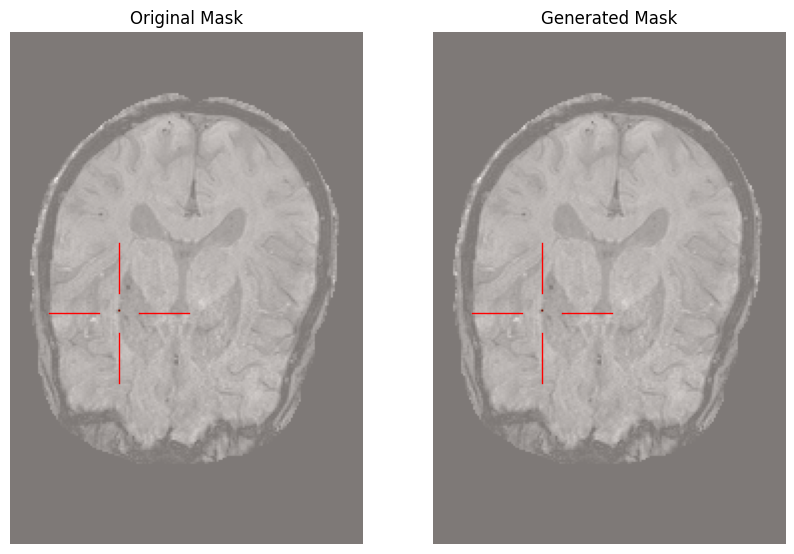

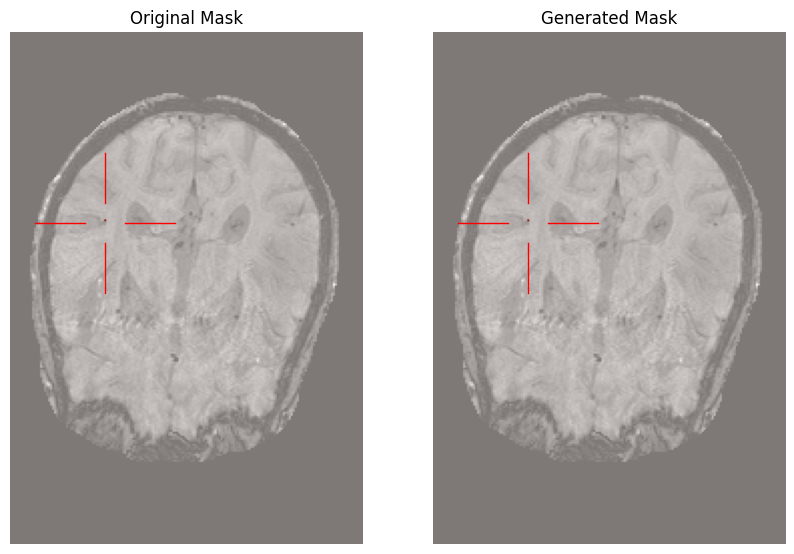

In [8]:
im1 = sequences_raw['SWI'].get_fdata()
cmb1 = labels_raw['SWI'].get_fdata()

for i, CM in enumerate(centersofmass):
    utils_plt.plot_processed_mask(
        im1, cmb1, labels_procesed.get_fdata(), CM, "SWI"
    )